In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.datasets import mnist
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.layers import Flatten,Conv2DTranspose,BatchNormalization,Dense,Reshape,concatenate,Conv2D,Input,Activation
import os
print(os.listdir("../input"))
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


[]


In [2]:
(xtrain,ytrain),(_,_)=mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
xtrain.shape

(60000, 28, 28)

In [4]:
#in Discriminator

# ylabels is onehot encoded labels of corresponding input
#images given as an input to discriminator model

In [5]:
X=xtrain.reshape((-1,28,28,1))
X=X.astype(np.float32)/255
y=to_categorical(ytrain,10)   #onehot encoding

In [6]:
#Defining Hyperparameters
latentdim=100
batchsize=128
epochs=40000
glayers=[128,64,32,1]
kernelsize=5


In [7]:
# Model Building

inp=Input(shape=(latentdim,))
y1=Input(shape=(10,))
x=concatenate([inp,y1])
x=Dense(7*7*glayers[0])(x)
x=Reshape((7,7,128))(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2DTranspose(filters=128,kernel_size=kernelsize,strides=2,padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2DTranspose(filters=64,kernel_size=kernelsize,strides=2,padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2DTranspose(filters=32,kernel_size=kernelsize,strides=1,padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2DTranspose(filters=1,kernel_size=kernelsize,strides=1,padding='same')(x)
out=Activation('sigmoid')(x)


In [8]:
generator=Model([inp,y1],out,name='generator')  # generator building

In [9]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6272)         696192      concatenate_1[0][0]              
__________

In [10]:
#Building Discriminator
discrimlayers=[32,64,128,256]
lr1=2e-4
decay1=6e-8
optimizer=Adam(lr=lr1,decay=decay1)

In [11]:
inp=Input((28,28,1))
label1=Input((10,))
y2=Dense(28*28)(label1)
y2=Reshape((28,28,1))(y2)
x=concatenate([inp,y2])
x=LeakyReLU(alpha=0.2)(x)
x=Conv2D(32,kernel_size=kernelsize,strides=2,padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=Conv2D(64,kernel_size=kernelsize,strides=2,padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=Conv2D(32,kernel_size=kernelsize,strides=2,padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=Conv2D(32,kernel_size=kernelsize,strides=1,padding='same')(x)
x=Flatten()(x)
x=Dense(1)(x)
out1=Activation('sigmoid')(x)

In [12]:
discriminator=Model([inp,label1],out1,name='discriminator')

In [13]:
#discriminator.summary()

In [14]:
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [15]:
#Building the Adversarial model
inp3=Input(shape=(latentdim,))
inp4=Input(shape=(28,28,1))
labels=Input(shape=(10,))
discriminator.trainable=False
output=discriminator([generator([inp3,labels]),labels])
adversarial=Model([inp3,labels],output,name='adversary')

In [16]:
optimizer1=Adam(lr=lr1*0.5,decay=decay1)
#adversarial.summary()


In [17]:
adversarial.compile(loss='binary_crossentropy',optimizer=optimizer1,metrics=['accuracy'])

In [18]:
plot_interval=20
noise_input=np.random.uniform(-1.0,1.0,size=[16,latentdim])
noiseclass=np.eye(10)[np.arange(0,16)%10]
Ntrain=len(xtrain)
epochs=30000

In [19]:
def plot_generator():
    noise_input=np.random.random(size=[10,latentdim])
    noiseclass=np.eye(10)[np.arange(10)]
    images=generator.predict([noise_input,noiseclass])
    fig,ax=plt.subplots(1,10)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    count=0
    for i in range(10):
        ax[i].imshow(images[count].reshape((28,28)))
        count+=1

In [20]:
noise=np.random.uniform(-1.0,1.0,size=(batchsize,latentdim))
fakelabels=np.eye(10)[np.random.choice(10,size=batchsize)]
fakeimage=generator.predict([noise,fakelabels])

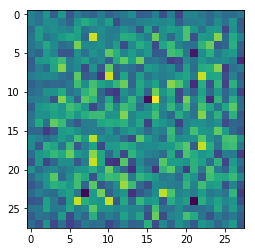

In [21]:
plt.imshow(fakeimage[3].reshape((28,28)))

epoch: 0  dloss: 0.69101673 ad_loss: 0.6904259 -----dacc: 0.41015625 ad_acc: 0.7421875
epoch: 500  dloss: 0.6981003 ad_loss: 0.6802646 -----dacc: 0.26953125 ad_acc: 1.0
epoch: 1000  dloss: 0.6578854 ad_loss: 0.5057414 -----dacc: 0.6015625 ad_acc: 0.9921875
epoch: 1500  dloss: 0.69970846 ad_loss: 0.6959716 -----dacc: 0.3828125 ad_acc: 0.2578125
epoch: 2000  dloss: 0.6935207 ad_loss: 0.6913641 -----dacc: 0.4453125 ad_acc: 0.78125
epoch: 2500  dloss: 0.6940553 ad_loss: 0.69464874 -----dacc: 0.48046875 ad_acc: 0.1640625
epoch: 3000  dloss: 0.6938004 ad_loss: 0.692789 -----dacc: 0.36328125 ad_acc: 0.46875
epoch: 3500  dloss: 0.69356376 ad_loss: 0.6921166 -----dacc: 0.390625 ad_acc: 0.7421875
epoch: 4000  dloss: 0.69367105 ad_loss: 0.6909554 -----dacc: 0.43359375 ad_acc: 1.0
epoch: 4500  dloss: 0.69288623 ad_loss: 0.69195515 -----dacc: 0.51953125 ad_acc: 0.8046875
epoch: 5000  dloss: 0.69281495 ad_loss: 0.69099855 -----dacc: 0.59765625 ad_acc: 1.0
epoch: 5500  dloss: 0.6935032 ad_loss: 0.694

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch: 20500  dloss: 0.69417685 ad_loss: 0.61952436 -----dacc: 0.5625 ad_acc: 0.7578125
epoch: 21000  dloss: 0.72067654 ad_loss: 0.6241125 -----dacc: 0.40234375 ad_acc: 0.7890625
epoch: 21500  dloss: 0.7482819 ad_loss: 0.4653381 -----dacc: 0.46875 ad_acc: 0.859375
epoch: 22000  dloss: 0.62841976 ad_loss: 0.82010585 -----dacc: 0.65234375 ad_acc: 0.2890625
epoch: 22500  dloss: 0.65238726 ad_loss: 0.7356083 -----dacc: 0.609375 ad_acc: 0.4140625
epoch: 23000  dloss: 0.61015725 ad_loss: 0.80690414 -----dacc: 0.69921875 ad_acc: 0.4609375
epoch: 23500  dloss: 0.6520511 ad_loss: 0.47330356 -----dacc: 0.609375 ad_acc: 0.953125
epoch: 24000  dloss: 0.6604301 ad_loss: 0.8897711 -----dacc: 0.65234375 ad_acc: 0.109375
epoch: 24500  dloss: 0.62487054 ad_loss: 0.47029692 -----dacc: 0.68359375 ad_acc: 0.8984375
epoch: 25000  dloss: 0.60251755 ad_loss: 0.69421923 -----dacc: 0.59375 ad_acc: 0.5625
epoch: 25500  dloss: 0.60294837 ad_loss: 0.7829752 -----dacc: 0.62109375 ad_acc: 0.625
epoch: 26000  dloss:

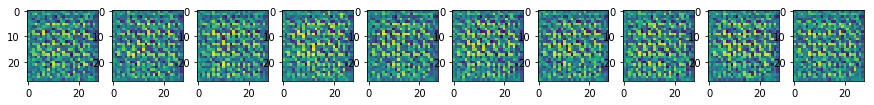

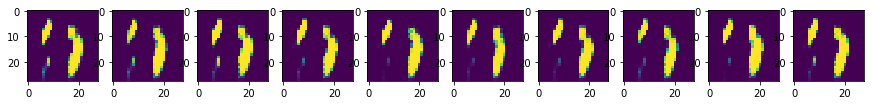

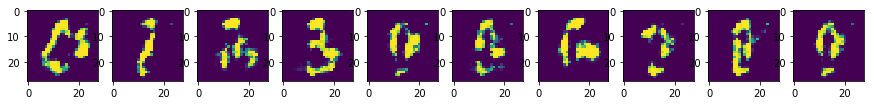

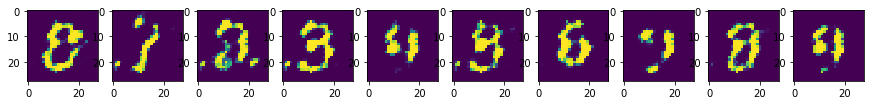

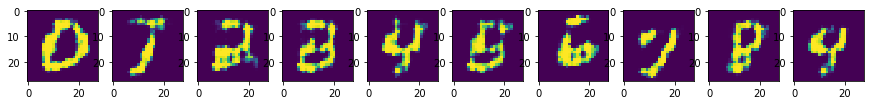

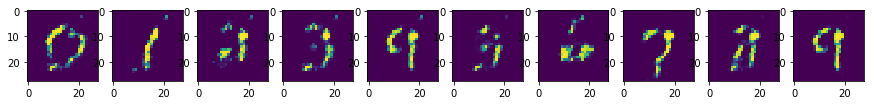

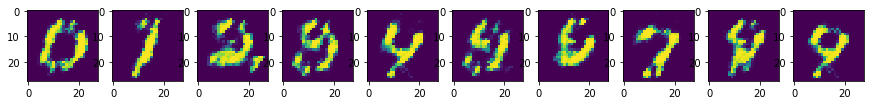

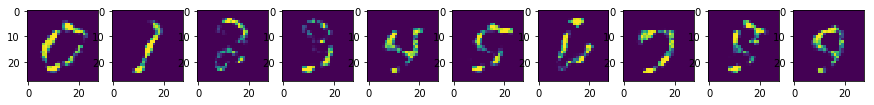

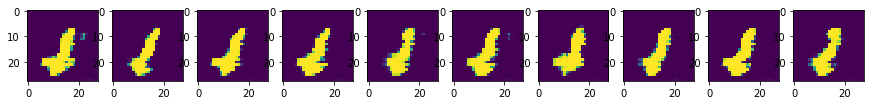

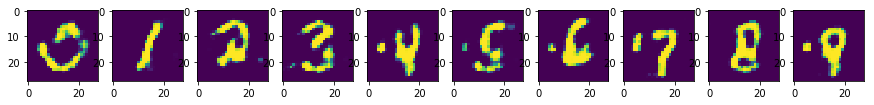

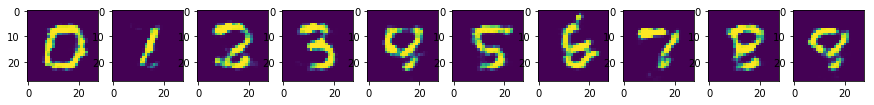

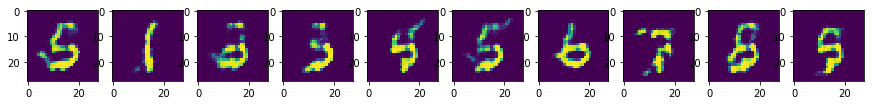

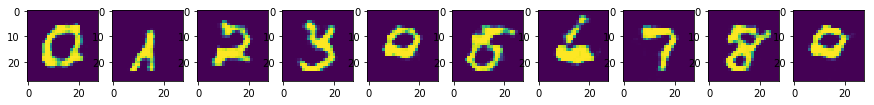

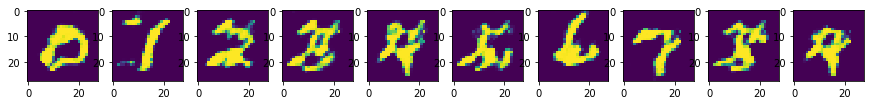

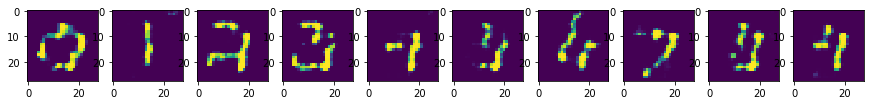

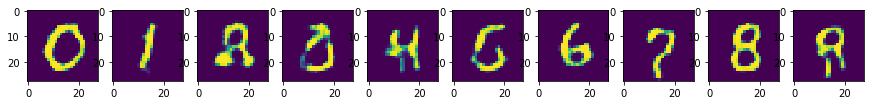

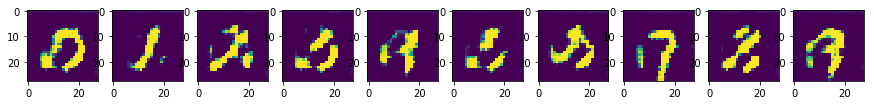

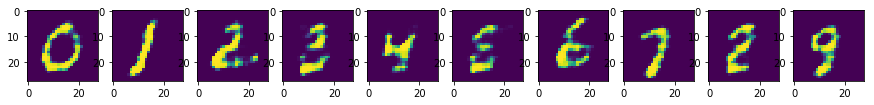

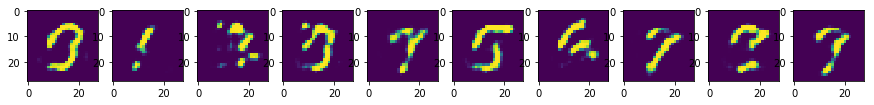

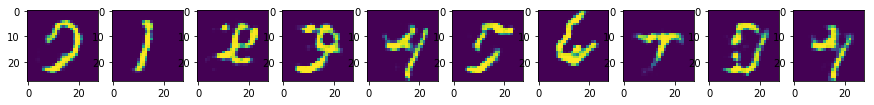

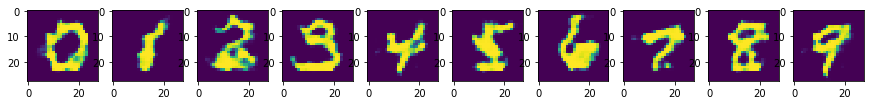

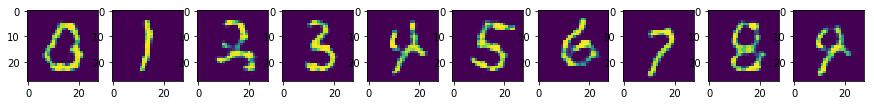

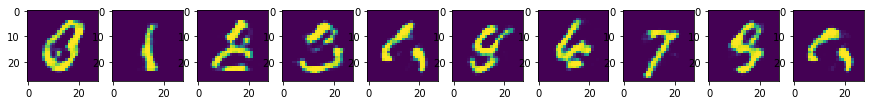

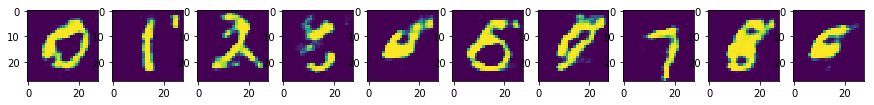

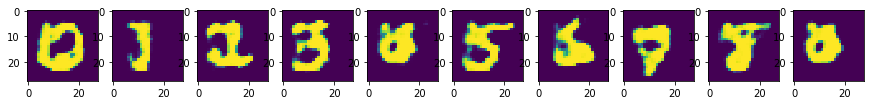

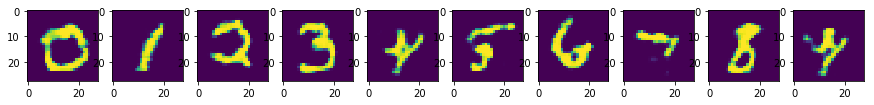

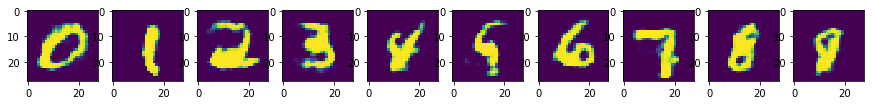

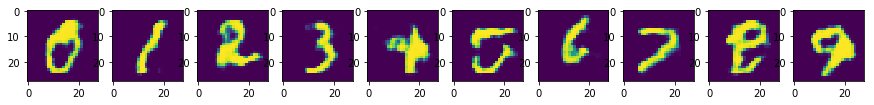

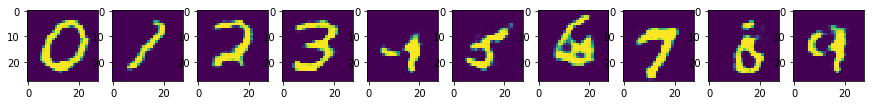

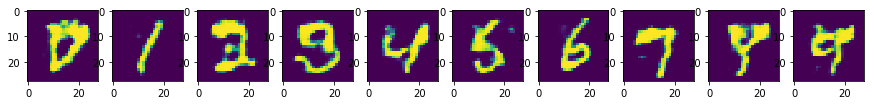

In [22]:
#Training
for i in range(epochs):
    
    #Training discriminator
    random_index=np.random.choice(Ntrain,size=batchsize,replace=False)
    batch_x=X[random_index]
    batch_y=y[random_index]
    noise=np.random.uniform(-1.0,1.0,size=(batchsize,latentdim))
    fakelabels=np.eye(10)[np.random.choice(10,size=batchsize)]
    fakeimages=generator.predict([noise,fakelabels])
    x=np.concatenate([batch_x,fakeimages])
    label3=np.concatenate([batch_y,fakelabels])
    y1=np.ones([2*batchsize,1])
    y1[batchsize:,0]=0.0
    discriminator.trainable=True
    dloss,dacc=discriminator.train_on_batch([x,label3],y1)
    
    #Training Adverasarial
    
    noise=np.random.uniform(-1.0,1.0,size=[batchsize,latentdim])
    fakelabel1=np.eye(10)[np.random.choice(10,size=batchsize)]
    y2=np.ones([batchsize,1])
    discriminator.trainable=False
    ad_loss,ad_acc=adversarial.train_on_batch([noise,fakelabel1],y2)
    ad_loss2,ad_acc2=adversarial.train_on_batch([noise,fakelabel1],y2)
    ad_loss3,ad_acc3=adversarial.train_on_batch([noise,fakelabel1],y2)
    if (i%500)==0:
        print("epoch:",i," dloss:",dloss,"ad_loss:",ad_loss3,"-----dacc:",dacc,'ad_acc:',ad_acc3)
        if (i%1000)==0:
            plot_generator()
    

In [23]:
noise=np.random.uniform(-1.0,1.0,size=(10,100))
label4=np.eye(10)[np.arange(10)]

In [24]:
a=generator.predict([noise,label4])

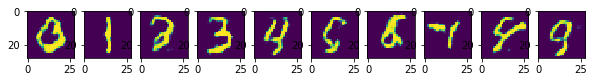

In [25]:
fig,axes=plt.subplots(1,10)
fig.set_figheight(10)
fig.set_figwidth(10)
count=0
for i in range(10):
    axes[i].imshow(a[count].reshape((28,28)))
    count+=1

In [26]:
# >>>> CGANS Completed <<<